
# Lab: Classification Methods


## The Stock Market Data

We will begin by examining some numerical and graphical summaries of
the `Smarket` data, which is part of the `ISLR2` library, but can also be found in the data directory. This
data set consists of percentage returns for the S\&P 500 stock index
over $1,250$~days, from the beginning of 2001 until the end of
2005. For each date, we have recorded the percentage returns for each
of the five previous trading days, `lagone` through `lagfive`. We
have also recorded `volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question)  and `direction` (whether the market was `Up` or `Down` on this date). Our goal is to predict `direction` (a qualitative response) using the other features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
Smarket = pd.read_csv('data/Smarket.csv', parse_dates=True)
Smarket['Direction'] = Smarket.Direction.astype('category')
Smarket['Direction_code'] = Smarket.Direction.cat.codes 
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_code
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


In [3]:
Smarket.shape

(1250, 10)

In [4]:
Smarket.describe(include='all')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_code
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250,1250.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648,NaN
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,NaN,0.518400
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,NaN,0.499861
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,NaN,0.000000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,NaN,0.000000
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,NaN,1.000000
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,NaN,1.000000


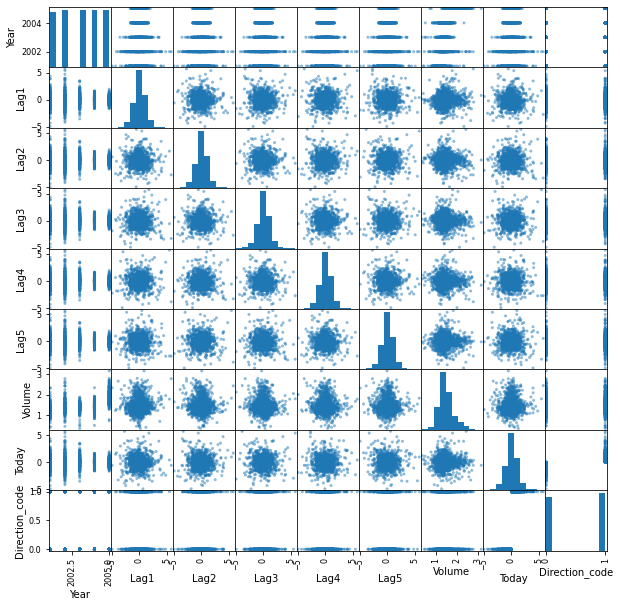

In [5]:
pd.plotting.scatter_matrix(Smarket, figsize=(10, 10));

The `cor()` function produces a matrix that contains all of the pairwise correlations among the predictors in a data set. Note that categorical columns are ignored, but have already included a column with encoded Direction.

In [6]:
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_code
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095,0.074608
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155,-0.039757
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250,-0.024081
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448,0.006132
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900,0.004215
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860,0.005423
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592,0.022951
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000,0.730563
Direction_code,0.074608,-0.039757,-0.024081,0.006132,0.004215,0.005423,0.022951,0.730563,1.000000


As one would expect, the correlations between the lag variables and today's returns are close to zero. In other words, there appears to be little correlation between today's returns and previous days' returns. The only substantial correlation is between `Year` and `volume`. By plotting the data, which is ordered chronologically, we see that `volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

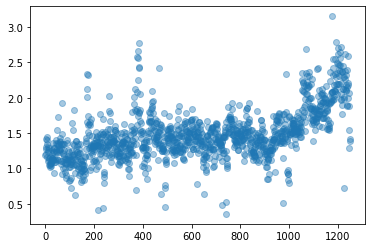

In [7]:
Smarket.Volume.plot(style='o', alpha=0.4);

## Logistic Regression

Next, we will fit a logistic regression model in order to predict `direction` using `lagone` through `lagfive` and `volume`. The `glm()` function  can be used to fit many types of generalized linear models , including logistic regression.
 The syntax of the `glm()` function is similar to that of  `lm()`,  except that we must pass in the argument `family = binomial` in order to tell `R` to run a logistic regression rather than some other type of generalized linear model.


In [8]:
X = Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
# In statsmodels we need to add the constant manually
X = sm.add_constant(X)
y = Smarket.Direction_code

In [9]:
log_model = sm.Logit(y, X).fit()
log_model.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         Direction_code   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                0.002074
Time:                        18:58:25   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest $p$-value here is associated with `lagone`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of $0.15$, the $p$-value is still relatively large, and so there is no clear evidence of a real association between `lagone` and `direction`. 

We use the `params` attribute in order to access just the coefficients for this fitted model. We can also use other attributes to access  particular aspects of the fitted model, such as the $p$-values for the coefficients.

In [10]:
log_model.params

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

In [11]:
log_model.pvalues

const     0.600700
Lag1      0.145232
Lag2      0.398352
Lag3      0.824334
Lag4      0.851445
Lag5      0.834998
Volume    0.392404
dtype: float64

The `predict()` function can be used to predict the probability that the market will go up, given values of the predictors. If no data set is supplied to the `predict()` function,
then  the probabilities are computed for the training data that was used to fit the logistic regression model. Here we have printed only the first ten probabilities. We know that these values correspond to the probability of the market going up, rather than down, by looking at the categories list of the codes column. Other option worth exploring is to fit the model using the `patsy` module together with `statsmodels` formula api.

In [12]:
Smarket.Direction.cat.categories

Index(['Down', 'Up'], dtype='object')

In [13]:
probs = log_model.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, `Up` or `Down`.
The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than $0.5$.

In [14]:
pred = np.array(['Down']*1250)
pred[probs > 0.5] = 'Up'
pred[:10]

array(['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down'],
      dtype='<U4')

The first command creates a vector of 1,250  `Down` elements. The second line transforms to `Up` all of the elements for which the predicted probability of a market increase exceeds $0.5$. Given these predictions, the `crosstab()` function can be used to produce a confusion matrix   in order to determine how many observations were correctly or incorrectly classified. %By inputting two qualitative vectors pandas will create a two by two table with counts of the number of times each combination occurred e.g. predicted {\it Up} and market increased, predicted {\it Up} and the market decreased etc.

In [15]:
pred = pd.Series(pred, name='pred')
pd.crosstab(pred, Smarket.Direction, margins=True)

Direction,Down,Up,All
pred,,,
Down,145,141,286
Up,457,507,964
All,602,648,1250


In [16]:
(507 + 145) / 1250

0.5216

In [17]:
np.mean(pred == Smarket.Direction)

0.5216

The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence our model correctly predicted that the market would go up on $507$ days and that it would go down on $145$ days, for a total of $507+145 = 652$ correct predictions. The `mean()` function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market  $52.2$\,\% of the time.

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the  model on the same set of $1,250$ observations. In other words,
 $100\%-52.2\%=47.8\%$, is the *training* error   rate. As we have seen previously, the training error rate is often overly optimistic---it tends to underestimate the   test error rate.  In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the *held out* data.
This will yield a more realistic error rate, in the sense that in practice we will be interested in our model's performance not on the data that we used to fit the model, but rather on days in the future for which the market's movements are unknown.

To implement this strategy, we will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.

In [18]:
Smarket[Smarket.Year < 2005]

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_code
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1
...,...,...,...,...,...,...,...,...,...,...
993,2004,0.046,0.342,0.904,0.038,-0.749,0.9561,-0.431,Down,0
994,2004,-0.431,0.046,0.342,0.904,0.038,0.9220,0.715,Up,1
995,2004,0.715,-0.431,0.046,0.342,0.904,0.9830,-0.007,Down,0
996,2004,-0.007,0.715,-0.431,0.046,0.342,0.9259,0.008,Up,1


In [19]:
train = Smarket.Year < 2005
X_train = X[train]
y_train  = y[train]
X_test = X[~train]
y_test = y[~train]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((998, 7), (998,), (252, 7), (252,))

The object `train` is a vector of $1{,}250$ elements, corresponding to the observations in our data set. The elements of the vector that correspond to observations that occurred before 2005 are set to `TRUE`, whereas those that correspond to observations  in 2005 are set to `FALSE`.
The object `train` is a  *Boolean*  vector, since its elements are `TRUE` and `FALSE`.
Boolean vectors can be used to obtain a subset of the rows or columns of a data frame. For instance, the command `Smarket[train]` would pick out a submatrix of the stock market data set, corresponding only to the dates before 2005, since
those are the ones for which the elements of `train` are `TRUE`.
The `~` symbol can be used to reverse all of the elements of  a Boolean vector. That is, `~train` is a vector similar to `train`, except that  the elements that are `TRUE` in `train` get swapped to `FALSE` in `~train`, and the elements that are `FALSE`
in `train` get swapped to `TRUE` in `~train`. Therefore, `Smarket[~train]` yields a submatrix of the stock market data containing only
the observations for which `train` is `FALSE`---that is, the observations with dates in 2005. The output above indicates that there are 252 such observations.

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005. We then obtain predicted probabilities of the stock market going up for each of the days in our test set---that is, for the days in 2005.

In [20]:
log_model = sm.Logit(y_train, X_train).fit()
probs = log_model.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005.
Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [23]:
pred = np.array(['Down']*252)
pred[probs > 0.5] = 'Up'
pred = pd.Series(pred, name='pred', index=probs.index)
pd.crosstab(pred, Smarket.Direction)

Direction,Down,Up
pred,,
Down,77,97
Up,34,44


In [24]:
np.mean(pred.values == Smarket[~train].Direction.values)

0.4801587301587302

In [25]:
np.mean(pred.values != Smarket[~train].Direction.values)

0.5198412698412699

The `!=` notation means *not equal to*, and  so the last command computes the  test set error rate. The results are rather disappointing: the test error rate is $52$\,\%, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to  use previous days' returns to predict future market performance. (After all, if it were possible to do so, then the authors of this book would be out striking it rich rather than writing a statistics textbook.)

We recall that the logistic regression model had very underwhelming $p$-values associated with all of the predictors, and that the smallest $p$-value, though not very small, corresponded to `lagone`. Perhaps by removing the variables that appear not  to be helpful in
predicting
`direction`, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement.
 Below we have refit the logistic regression using just `lagone` and `lagtwo`, which seemed to have the highest predictive power in the original logistic regression model.

In [27]:
X_train = X[['const', 'Lag1', 'Lag2']][train]
X_test = X[['const', 'Lag1', 'Lag2']][~train]
log_model = sm.Logit(y_train, X_train).fit()
probs = log_model.predict(X_test)
pred = np.array(['Down']*252)
pred[probs > 0.5] = 'Up'
pred = pd.Series(pred, name='pred', index=probs.index)
pd.crosstab(pred, Smarket.Direction)

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


Direction,Down,Up
pred,,
Down,35,35
Up,76,106


In [28]:
np.mean(pred.values == Smarket[~train].Direction.values)

0.5595238095238095

In [29]:
106 / (106 + 76)

0.5824175824175825

Now the results appear to be a little better: $56\%$ of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will also be correct $56\%$ of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a $58\%$ accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular values of `lagone` and `lagtwo`. In particular, we want to predict `direction` on a day when `lagone` and `lagtwo` equal 1.2 and~1.1, respectively, and  on a day when they equal  1.5 and $-$0.8.
We do this using the `predict()` function.

In [30]:
log_model.predict(pd.DataFrame({'const': [1, 1], 'Lag1': [1.2, 1.5], 'Lag2': [1.1, -0.8]}))

0    0.479146
1    0.496094
dtype: float64

## Linear Discriminant Analysis

Now we will perform LDA on the `Smarket` data. In `R`, we fit an LDA model using Scikit-Learn.

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [35]:
# Scikit-Learn does not require to manually add the constant term
X_train = Smarket[['Lag1', 'Lag2']][train]
X_test = Smarket[['Lag1', 'Lag2']][~train]

In [36]:
lda = LDA().fit(X_train, y_train)

In [37]:
print('Prior probabilities of groups:')
print('Down   Up')
print(lda.classes_)
print(lda.priors_)

Prior probabilities of groups:
Down   Up
[0 1]
[0.49198397 0.50801603]


In [38]:
print('Group means:')
pd.DataFrame(lda.means_, columns=['Lag1', 'Lag2'], index=['Down', 'Up'])

Group means:


,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


In [39]:
print('Coefficients and intercept of the linear log probability')
lda.coef_, lda.intercept_

Coefficients and intercept of the linear log probability


(array([[-0.05544078, -0.0443452 ]]), array([0.03221375]))

The LDA output indicates that $\hat\pi_1=0.492$ and $\hat\pi_2=0.508$; in other words, $49.2$\,\% of the training observations correspond to days during which the market went down.
 It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$.
 These suggest that there is a tendency for the previous 2~days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines.
  The *coefficients of linear discriminants* output provides the linear combination of `lagone` and `lagtwo` that are used to form the LDA decision rule, toguether with the intercept, they give the log posteriori probabilioty (up to a constatn) for each class. In other words, these are the multipliers of the elements of $X=x$ in ( 4.24).

The `predict()` function returns LDA's predictions about the movement of the market.

In [41]:
lda.predict(X_test)[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

The `predict_proba()` function returns a matrix whose $k$th column contains the posterior probability that the corresponding observation belongs to the $k$th class.

In [42]:
lda.predict_proba(X_test)[:10]

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738]])

The `decision_function()` contains the linear discriminants, described earlier. In a binary classification setting this instead corresponds to the difference between log likelihoods.

In [43]:
lda.decision_function(X_test)[:10]

array([0.03928805, 0.08317392, 0.13292144, 0.1040896 , 0.02885135,
       0.02457662, 0.01959437, 0.05086657, 0.03719889, 0.06240975])

In [44]:
lda.coef_ @ X_test[:10].values.T + lda.intercept_

array([[0.03928805, 0.08317392, 0.13292144, 0.1040896 , 0.02885135,
        0.02457662, 0.01959437, 0.05086657, 0.03719889, 0.06240975]])

As we observed in Section 4.5, the LDA and logistic regression predictions are almost identical.

In [45]:
pred = lda.predict(X_test)
pd.crosstab(pred, y_test, margins=True)

Direction_code,0,1,All
row_0,,,
0,35,35,70
1,76,106,182
All,111,141,252


In [46]:
np.mean(pred == y_test)

0.5595238095238095

Applying a $50$\,\% threshold to the posterior probabilities allows us to recreate the predictions contained in `lda.pred$class`.

In [47]:
probs = lda.predict_proba(X_test)[:,1]
(probs >= 0.5).sum()

182

In [48]:
(probs < 0.5).sum()

70

If we wanted to use a posterior probability threshold other than $50$\,\% in order to make predictions, then we could easily do so. For instance, suppose that we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day---say, if the posterior probability
is at most $10$\,\%.

In [49]:
sum(probs < 0.1)

0

No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was $52.02$\,\%.

## Quadratic Discriminant Analysis

We will now fit a QDA model to the `Smarket` data. QDA is  implemented in `Scikit-Learn`.

In [50]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [51]:
qda = QDA().fit(X_train, y_train)

In [52]:
print('Prior probabilities of groups:')
print('Down   Up')
print(qda.classes_)
print(qda.priors_)

Prior probabilities of groups:
Down   Up
[0 1]
[0.49198397 0.50801603]


In [53]:
print('Group means:')
pd.DataFrame(qda.means_, columns=['Lag1', 'Lag2'], index=['Down', 'Up'])

Group means:


,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


The `predict()` function works in exactly the same fashion as for LDA.

In [54]:
pred = qda.predict(X_test)
pd.crosstab(pred, y_test, margins=True)

Direction_code,0,1,All
row_0,,,
0,30,20,50
1,81,121,202
All,111,141,252


In [55]:
np.mean(pred == y_test)

0.5992063492063492

Interestingly, the QDA predictions are accurate almost $60$\,\% of the time, even though the 2005 data was not used  to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite hard to model accurately.
This  suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression.
 However, we recommend evaluating this method's performance on a larger test set  before betting  that this approach will consistently beat the market!

## Naive Bayes

Next, we fit a naive Bayes model to the `Smarket` data. Naive Bayes is implemented in `Scikit-Learn` using the `GaussianNB()` function.
By default, this implementation of the naive Bayes classifier models each quantitative feature using a Gaussian distribution. However, other functions for Naive Bayes under different distributions are also available, see the Scikit-Learn documentation.

In [56]:
from sklearn.naive_bayes import GaussianNB as GNB

In [57]:
nb = GNB().fit(X_train, y_train)

In [58]:
print('Prior probabilities of groups:')
print('Down   Up')
print(nb.classes_)
print(nb.class_prior_)

Prior probabilities of groups:
Down   Up
[0 1]
[0.49198397 0.50801603]


In [59]:
print('Conditional probabilities mean values:')
pd.DataFrame(nb.theta_, columns=X_train.columns, index=['Down', 'Up'])

Conditional probabilities mean values:


,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


In [216]:
print('Conditional probabilities std:')
pd.DataFrame(np.sqrt(nb.var_), columns=X_train.columns, index=['Down', 'Up'])

Conditional probabilities std:


,Lag1,Lag2
Down,1.226195,1.237929
Up,1.230453,1.219561


The output  contains the estimated mean and standard deviation for each variable in each class. For example, the mean for `lagone` is $0.0428$ for 

  `Direction=Down`, and the standard deviation is $1.23$. We can easily verify this:

In [60]:
np.mean(X_train.Lag1.values[y_train == 0])

0.04279022403258655

In [61]:
np.std(X_train.Lag1.values[y_train == 0])

1.226195046492573

The `predict()` function is straightforward.

In [62]:
pred = nb.predict(X_test)
pd.crosstab(pred, y_test, margins=True)

Direction_code,0,1,All
row_0,,,
0,29,20,49
1,82,121,203
All,111,141,252


In [63]:
np.mean(pred == y_test)

0.5952380952380952

Naive Bayes performs very well on this data, with accurate predictions over $59\%$ of the time. This is slightly worse than QDA, but much better than LDA.

The `predict_proba()` function can also generate estimates of the probability that each observation belongs to a particular class. %

In [65]:
probs = nb.predict_proba(X_test)
probs[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

## $K$-Nearest Neighbors

We will now perform KNN using the `KNeighborsClassifier()` function, which is part of the `Scikit-Learn` library.

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN

In [67]:
knn = KNN(n_neighbors=1).fit(X_train, y_train)

In [68]:
pred = knn.predict(X_test)
pd.crosstab(pred, y_test)

Direction_code,0,1
row_0,,
0,43,58
1,68,83


In [69]:
(83 + 43) / 252

0.5

The results using $K=1$ are not very good,  since only $50$\,\% of the observations are correctly predicted. Of course, it may be that $K=1$ results in  an overly flexible fit to the data. Below, we repeat the analysis using $K=3$.

In [70]:
knn = KNN(n_neighbors=3).fit(X_train, y_train)
pred = knn.predict(X_test)
pd.crosstab(pred, y_test)

Direction_code,0,1
row_0,,
0,48,55
1,63,86


In [71]:
np.mean(pred == y_test)

0.5317460317460317

The results have improved slightly. But increasing $K$ further turns out to provide no further improvements. It appears that for this data, QDA provides the best results of the methods that we have examined so far.



KNN does not perform well on the `Smarket` data but it does often provide impressive results. As an example we will apply the KNN approach to the `Caravan` data set, which is part of the `ISLR2` library. This data set includes $85$ predictors that measure
 demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only $6$\,\% of people purchased caravan  insurance.


In [72]:
Caravan = pd.read_csv('data/Caravan.csv')
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [73]:
Caravan.shape

(5822, 86)

In [74]:
Caravan.Purchase.describe()

count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [75]:
Caravan.Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [76]:
348 / 5822

0.05977327378907592

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Variables that are on a large scale will have a much larger effect
 on the *distance* between the observations, and hence
on the KNN classifier, than variables that are on a small scale. For instance, imagine a data set that contains two variables, `salary` and `age` (measured in dollars and years, respectively). As far as KNN is concerned, a difference of \\$1,000 in salary is enormous compared to a difference of $50$ years in age. Consequently, `salary` will drive the KNN classification results, and `age` will have almost no effect. This is contrary to our intuition  that a salary difference of $\$1{,}000$ is quite small compared to an age difference of $50$ years.
Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured `salary` in Japanese yen, or if we measured `age` in minutes, then we'd get quite different classification results from what we get if these two variables are measured in dollars and years.

A good way to handle this problem is to  the data so that all variables are given a mean of  zero and  a standard deviation of one. Then all variables will be on a comparable scale. The `StandardScaler()` does just this.
 In standardizing the data, we exclude column $86$, because that is the qualitative `Purchase` variable.

In [77]:
X = Caravan[Caravan.columns.drop('Purchase')]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X.var(axis=0)

MOSTYPE     165.037847
MAANTHUI      0.164708
MGEMOMV       0.623839
MGEMLEEF      0.663555
MOSHOOFD      8.161077
               ...    
AZEILPL       0.000515
APLEZIER      0.006664
AFIETS        0.044515
AINBOED       0.008184
ABYSTAND      0.014399
Length: 85, dtype: float64

In [78]:
X_scaled.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Now every column of `X_scaled` has a standard deviation of one and a mean of zero.

We now split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations.
We fit  a KNN model on the training data using $K=1$, and evaluate its performance on the test data.%

In [79]:
X_test = X_scaled[:1000]
y_test = Caravan.Purchase[:1000]
X_train = X_scaled[1000:]
y_train = Caravan.Purchase[1000:]

In [80]:
knn = KNN(n_neighbors=1).fit(X_train, y_train)

In [81]:
pred = knn.predict(X_test)
np.mean(pred != y_test)

0.118

In [83]:
np.mean(y_test != 'No')

0.059

The KNN error rate on the 1,000 test observations is just under $12$\,\%. At first glance, this may appear to be fairly good. However, since only $6$\,\% of customers purchased insurance, we could get the error rate down to $6$\,\% by always predicting `No` regardless of
the values of the predictors!

Suppose that there is some non-trivial cost to trying to sell insurance to a given individual. For instance, perhaps a salesperson must  visit each potential customer.
If the company tries to sell insurance to a random selection of customers, then the success rate will be only $6$\,\%, which may be far too low given the costs involved.
Instead, the company would like to try to sell insurance only to customers who are likely to buy it. So the  overall error rate is not of interest. Instead,  the fraction of individuals that are correctly predicted to buy insurance is of interest.

 It turns out that KNN with $K=1$ does far better than random guessing among the customers that are predicted to buy insurance. Among  $77$ such customers, $9$, or $11.7$\,\%, actually do purchase insurance.
 This is  double the rate that one would obtain from random guessing.

In [84]:
pd.crosstab(pred, y_test)

Purchase,No,Yes
row_0,,
No,873,50
Yes,68,9


In [85]:
9 / (68 + 9)

0.11688311688311688

Using $K=3$, the success rate increases to $20$\,\%, and with $K=5$ the rate is $28.6$\,\%. This is  over four times the rate that results from random guessing. It appears that KNN is finding some real patterns in a difficult data set!

In [86]:
knn = KNN(n_neighbors=3).fit(X_train, y_train)
pred = knn.predict(X_test)
pd.crosstab(pred, y_test)

Purchase,No,Yes
row_0,,
No,921,54
Yes,20,5


In [87]:
5 / 25

0.2

In [88]:
knn = KNN(n_neighbors=5).fit(X_train, y_train)
pred = knn.predict(X_test)
pd.crosstab(pred, y_test)

Purchase,No,Yes
row_0,,
No,931,55
Yes,10,4


In [89]:
4 / 14

0.2857142857142857

However, while this strategy is cost-effective, it is worth noting that only 14 customers are predicted to purchase insurance using KNN with $K=5$. In practice, the insurance company may wish to expend resources on convincing more than just 14 potential customers to buy insurance.

As a comparison, we can also fit a logistic regression model to the data. If we use $0.5$ as the predicted probability cut-off for the classifier, then we have a problem: only seven of the test observations are predicted to purchase insurance. Even worse, we are wrong about all of these!
 However, we are not required to use a cut-off of  $0.5$. If we instead predict a purchase any time the predicted probability of purchase exceeds  $0.25$, we get much better results: we predict that 33 people will purchase insurance, and
 we are correct for about $32$\,\% of these people. This is  over five times better than random guessing!

In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
log_model = LogisticRegression(penalty='none', max_iter=1000).fit(X_train, y_train)
probs = log_model.predict_proba(X_test)[:,1]
pred = np.array(['No']*1000)
pred[probs > 0.5] = 'Yes'
pd.crosstab(pred, y_test)

Purchase,No,Yes
row_0,,
No,934,59
Ye,7,0


In [92]:
log_model = LogisticRegression(penalty='none', max_iter=1000).fit(X_train, y_train)
probs = log_model.predict_proba(X_test)[:,1]
pred = np.array(['No']*1000)
pred[probs > 0.25] = 'Yes'
pd.crosstab(pred, y_test)

Purchase,No,Yes
row_0,,
No,918,48
Ye,23,11


In [93]:
11 / (23 + 11)

0.3235294117647059

## Poisson Regression

Finally, we fit a  Poisson regression model to the `Bikeshare` data set, which measures the number of bike rentals (`bikers`) per hour in Washington, DC. The data can be found in the `ISLR2` library.


In [122]:
Bikershare = pd.read_csv('data/Bikeshare.csv', index_col=0)
Bikershare.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
1,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
2,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
3,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
4,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
5,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


In [98]:
Bikershare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 1 to 8645
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8645 non-null   int64  
 1   mnth        8645 non-null   object 
 2   day         8645 non-null   int64  
 3   hr          8645 non-null   int64  
 4   holiday     8645 non-null   int64  
 5   weekday     8645 non-null   int64  
 6   workingday  8645 non-null   int64  
 7   weathersit  8645 non-null   object 
 8   temp        8645 non-null   float64
 9   atemp       8645 non-null   float64
 10  hum         8645 non-null   float64
 11  windspeed   8645 non-null   float64
 12  casual      8645 non-null   int64  
 13  registered  8645 non-null   int64  
 14  bikers      8645 non-null   int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 1.1+ MB


We begin by fitting a least squares linear regression model to the data.

In [172]:
y = Bikershare.bikers
X = Bikershare[['mnth', 'hr', 'workingday', 'temp', 'weathersit']].copy()
X['hr'] = X.hr.astype('category')
X['mnth'] = X.mnth.astype('category')
X['mnth'] = X.mnth.cat.reorder_categories(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
X = sm.add_constant(X)
X.head()

,const,mnth,hr,workingday,temp,weathersit
1,1.0,Jan,0,0,0.24,clear
2,1.0,Jan,1,0,0.22,clear
3,1.0,Jan,2,0,0.22,clear
4,1.0,Jan,3,0,0.24,clear
5,1.0,Jan,4,0,0.24,clear


In [173]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,const,workingday,temp,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,mnth_Aug,...,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weathersit_cloudy/misty,weathersit_heavy rain/snow,weathersit_light rain/snow
1,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0.22,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,0.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:05:54   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -68.6317      5.307    -12.932      0.000     -79.035     -58.229
workingday                     1.2696      1.784      0.711      0.477      -2.228       4.768
temp                         157.2094     10.261     15.321      0.000     137.095     177.324
mnth_Feb                       6.8452      4.287      1.597      0.110      -1.559      15.250
mnth_March                    16.5514      4.301      3.848      0.000       8.120      24.983
mnth_April                    41.4249      4.972      8.331      0.000      31.678      51.172
mnth_May                      72.5571      5.641     12.862      0.000      61.499      83.615
mnth_June                     67.8187      6.544     10.364      0.000      54.992      80.646
mnth_July                     45.3245      7.081      6.401      0.000      31.444      59.205
mnth_Aug                      53.2430      6.640      8.019      0.000      40.227      66.259
mnth_Sept                     66.6783      5.925     11.254      0.000      55.064      78.293
mnth_Oct                      75.8343      4.950     15.319      0.000      66.130      85.538
mnth_Nov                      60.3100      4.610     13.083      0.000      51.273      69.347
mnth_Dec                      46.4577      4.271     10.878      0.000      38.086      54.829
hr_1                         -14.5793      5.699     -2.558      0.011     -25.750      -3.408
hr_2                         -21.5791      5.733     -3.764      0.000     -32.817     -10.341
hr_3                         -31.1408      5.778     -5.389      0.000     -42.468     -19.814
hr_4                         -36.9075      5.802     -6.361      0.000     -48.281     -25.534
hr_5                         -24.1355      5.737     -4.207      0.000     -35.381     -12.890
hr_6                          20.5997      5.704      3.612      0.000       9.419      31.781
hr_7                         120.0931      5.693     21.095      0.000     108.934     131.253
hr_8                         223.6619      5.690     39.310      0.000     212.509     234.815
hr_9                         120.5819      5.693     21.182      0.000     109.423     131.741
hr_10                         83.8013      5.705     14.689      0.000      72.618      94.985
hr_11                        105.4234      5.722     18.424      0.000      94.207     116.640
hr_12                        137.2837      5.740     23.916      0.000     126.032     148.536
hr_13                        136.0359      5.760     23.617      0.000     124.745     147.327
hr_14                        126.6361      5.776     21.923      0.000     115.313     137.959
hr_15                        132.0865      5.780     22.852      0.000     120.756     143.417
hr_16                        178.5206      

In `lm`, the first level of `hr` (0) and `mnth` (Jan) are treated as the baseline values, and so no coefficient estimates are provided for them: implicitly, their coefficient estimates are zero, and all other levels are measured relative to these baselines. For example, the Feb coefficient of $6.845$ signifies that, holding all other variables constant, there are on average about 7 more riders in February than in January. Similarly there are about 16.5 more riders in March than in January.

The results seen in Section 4.6.1 used a slightly different coding of the variables `hr` and `mnth`, as follows:

In [176]:
def set_sum_coding(df, prefix):
    df = df.copy()
    cols = [c for c in df.columns if c.startswith(prefix)]
    mask = df[cols].sum(axis=1).astype(bool)
    df.loc[~mask, cols] = -1
    return df

In [185]:
Bikershare.hr.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [192]:
y = Bikershare.bikers
X = Bikershare[['mnth', 'hr', 'workingday', 'temp', 'weathersit']].copy()
X['hr'] = X.hr.astype('category')
X['mnth'] = X.mnth.astype('category')
X['mnth'] = X.mnth.cat.reorder_categories(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
X = sm.add_constant(X)

X = pd.get_dummies(X, drop_first=False, dtype=int) # Signed int type needed for sum encoding below
X.drop(columns=['mnth_Dec', 'hr_23', 'weathersit_clear'], inplace=True)

#X = set_sum_coding(X, 'weathersit')
X = set_sum_coding(X, 'mnth')
X = set_sum_coding(X, 'hr')
X.head()

,const,workingday,temp,mnth_Jan,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,...,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,weathersit_cloudy/misty,weathersit_heavy rain/snow,weathersit_light rain/snow
1,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0.22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0.22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
lm2 = sm.OLS(y, X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 bikers   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     457.3
Date:                Tue, 20 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:14:00   Log-Likelihood:                -49743.
No. Observations:                8645   AIC:                         9.957e+04
Df Residuals:                    8605   BIC:                         9.985e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         73.5974      5.132     14.340      0.000      63.537      83.658
workingday                     1.2696      1.784      0.711      0.477      -2.228       4.768
temp                         157.2094     10.261     15.321      0.000     137.095     177.324
mnth_Jan                     -46.0871      4.085    -11.281      0.000     -54.096     -38.079
mnth_Feb                     -39.2419      3.539    -11.088      0.000     -46.179     -32.304
mnth_March                   -29.5357      3.155     -9.361      0.000     -35.721     -23.351
mnth_April                    -4.6622      2.741     -1.701      0.089     -10.034       0.710
mnth_May                      26.4700      2.851      9.285      0.000      20.882      32.058
mnth_June                     21.7317      3.465      6.272      0.000      14.939      28.524
mnth_July                     -0.7626      3.908     -0.195      0.845      -8.424       6.899
mnth_Aug                       7.1560      3.535      2.024      0.043       0.227      14.085
mnth_Sept                     20.5912      3.046      6.761      0.000      14.621      26.561
mnth_Oct                      29.7472      2.700     11.019      0.000      24.455      35.039
mnth_Nov                      14.2229      2.860      4.972      0.000       8.616      19.830
hr_0                         -96.1420      3.955    -24.307      0.000    -103.895     -88.389
hr_1                        -110.7213      3.966    -27.916      0.000    -118.496    -102.947
hr_2                        -117.7212      4.016    -29.310      0.000    -125.594    -109.848
hr_3                        -127.2828      4.081    -31.191      0.000    -135.282    -119.283
hr_4                        -133.0495      4.117    -32.319      0.000    -141.119    -124.980
hr_5                        -120.2775      4.037    -29.794      0.000    -128.191    -112.364
hr_6                         -75.5424      3.992    -18.925      0.000     -83.367     -67.718
hr_7                          23.9511      3.969      6.035      0.000      16.172      31.730
hr_8                         127.5199      3.950     32.284      0.000     119.777     135.263
hr_9                          24.4399      3.936      6.209      0.000      16.724      32.155
hr_10                        -12.3407      3.936     -3.135      0.002     -20.056      -4.625
hr_11                          9.2814      3.945      2.353      0.019       1.549      17.014
hr_12                         41.1417      3.957     10.397      0.000      33.385      48.899
hr_13                         39.8939      3.975     10.036      0.000      32.102      47.686
hr_14                         30.4940      3.991      7.641      0.000      22.671      38.317
hr_15                         35.9445      

What is the difference between the two codings?  In `lm2`,  a coefficient estimate is reported for all but the last level of `hr` and `mnth`. Importantly, in `lm2`, the coefficient estimate for the last level of `mnth` is not zero: instead, it equals the *negative of the sum of the coefficient estimates for all of the other levels*. Similarly, in `lm2`, the coefficient estimate for the last level of `hr` is the negative of the sum of the coefficient estimates for all of the other levels. This means that the coefficients of `hr` and `mnth` in `lm2` will always sum to zero, and can be interpreted as the difference from the mean level. For example, the coefficient for January of $-46.087$ indicates that, holding all other variables constant, there are typically 46 fewer riders in January relative to the yearly average.

It is important to realize that the choice of coding really does not matter, provided that we interpret the model output correctly in light of the coding used. For example, we see   that the predictions from the linear model are the same regardless of coding:

In [197]:
np.sum((lm.predict() - lm2.predict())**2)

3.700583438492766e-21

The sum of squared differences is zero. We can also see this using the `allclose()` function:

In [201]:
np.allclose(lm.predict(), lm2.predict())

True

To reproduce the left-hand side of Figure 4.13, we must first obtain the coefficient estimates associated with `mnth`. The coefficients for January through November can be obtained directly from the `lm2` object. The coefficient for December must be explicitly computed as the negative sum of all the other months.

In [212]:
coef_months = lm2.params[lm2.params.index.str.startswith('mnth')].to_list()
coef_months.append(-sum(coef_months))
coef_months

[-46.08709039388042,
 -39.241887612541404,
 -29.535652459721202,
 -4.662183493129998,
 26.469993141622535,
 21.731658419339656,
 -0.7626303956266955,
 7.155950440435166,
 20.591186132190252,
 29.74716195095169,
 14.222912526896675,
 0.3705817434637737]

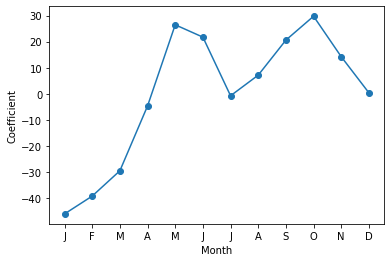

In [217]:
plt.plot(coef_months, 'o-')
plt.ylabel('Coefficient')
plt.xlabel('Month')
plt.xticks(range(12), ["J", "F", "M", "A",
    "M", "J", "J", "A", "S", "O", "N", "D"]);

To make the plot, we manually label the $x$-axis with the names of the months.

Reproducing the right-hand side of Figure 4.13 follows a similar process.

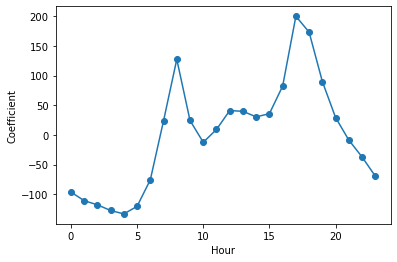

In [221]:
coef_hr = lm2.params[lm2.params.index.str.startswith('hr')].to_list()
coef_hr.append(-sum(coef_hr))

plt.plot(coef_hr, 'o-')
plt.ylabel('Coefficient')
plt.xlabel('Hour');

Now, we consider instead fitting a Poisson regression model to the `Bikeshare` data. Very little changes, except that we now use the function `glm()` with the argument `family = poisson` to specify that we wish to  fit a Poisson regression model:

In [243]:
y = Bikershare.bikers
X = Bikershare[['mnth', 'hr', 'workingday', 'temp', 'weathersit']].copy()
X['hr'] = X.hr.astype('category')
X['mnth'] = X.mnth.astype('category')
X['mnth'] = X.mnth.cat.reorder_categories(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
X = sm.add_constant(X)

X = pd.get_dummies(X, drop_first=False, dtype=int)
X.drop(columns=['mnth_Dec', 'hr_23', 'weathersit_clear'], inplace=True)

X = set_sum_coding(X, 'mnth')
X = set_sum_coding(X, 'hr')
X.head()

,const,workingday,temp,mnth_Jan,mnth_Feb,mnth_March,mnth_April,mnth_May,mnth_June,mnth_July,...,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,weathersit_cloudy/misty,weathersit_heavy rain/snow,weathersit_light rain/snow
1,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0.22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0.22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,0.24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [244]:
pois = sm.GLM(y, X, family=sm.families.Poisson()).fit()
pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8605
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4054e+05
Date:                Tue, 20 Sep 2022   Deviance:                   2.2804e+05
Time:                        11:42:50   Pearson chi2:                 2.20e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.1182      0.006    683.963      0.000       4.106       4.130
workingday                     0.0147      0.002      7.502      0.000       0.011       0.018
temp                           0.7853      0.011     68.434      0.000       0.763       0.808
mnth_Jan                      -0.6702      0.006   -113.445      0.000      -0.682      -0.659
mnth_Feb                      -0.4441      0.005    -91.379      0.000      -0.454      -0.435
mnth_March                    -0.2937      0.004    -70.886      0.000      -0.302      -0.286
mnth_April                     0.0215      0.003      6.888      0.000       0.015       0.028
mnth_May                       0.2405      0.003     82.462      0.000       0.235       0.246
mnth_June                      0.2232      0.004     62.818      0.000       0.216       0.230
mnth_July                      0.1036      0.004     25.121      0.000       0.096       0.112
mnth_Aug                       0.1512      0.004     41.281      0.000       0.144       0.158
mnth_Sept                      0.2335      0.003     75.281      0.000       0.227       0.240
mnth_Oct                       0.2676      0.003     96.091      0.000       0.262       0.273
mnth_Nov                       0.1503      0.003     47.248      0.000       0.144       0.156
hr_0                          -0.7544      0.008    -95.744      0.000      -0.770      -0.739
hr_1                          -1.2260      0.010   -123.173      0.000      -1.245      -1.206
hr_2                          -1.5631      0.012   -131.702      0.000      -1.586      -1.540
hr_3                          -2.1983      0.016   -133.846      0.000      -2.230      -2.166
hr_4                          -2.8305      0.023   -125.586      0.000      -2.875      -2.786
hr_5                          -1.8147      0.013   -134.775      0.000      -1.841      -1.788
hr_6                          -0.4299      0.007    -62.341      0.000      -0.443      -0.416
hr_7                           0.5752      0.004    130.544      0.000       0.567       0.584
hr_8                           1.0769      0.004    302.220      0.000       1.070       1.084
hr_9                           0.5818      0.004    135.727      0.000       0.573       0.590
hr_10                          0.3369      0.005     71.372      0.000       0.328       0.346
hr_11                          0.4941      0.004    112.494      0.000       0.486       0.503
hr_12                          0.6796      0.004    167.040      0.000       0.672       0.688
hr_13                          0.6736      0.004    164.722      0.000       0.666       0.682
hr_14                          0.6249      0.004    149.570      0.000       0.617       0.633
hr_15                          0.6538      

We can plot the coefficients associated with `mnth` and `hr`, in order to reproduce Figure 4.15:

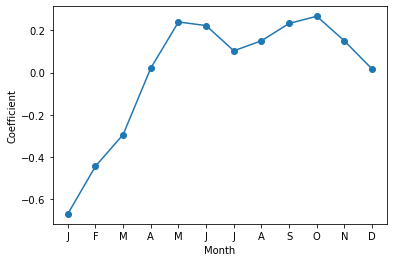

In [245]:
coef_months = pois.params[pois.params.index.str.startswith('mnth')].to_list()
coef_months.append(-sum(coef_months))
plt.plot(coef_months, 'o-')
plt.ylabel('Coefficient')
plt.xlabel('Month')
plt.xticks(range(12), ["J", "F", "M", "A",
    "M", "J", "J", "A", "S", "O", "N", "D"]);

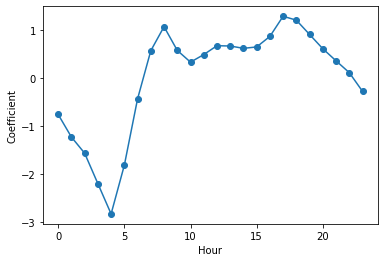

In [246]:
coef_hr = pois.params[pois.params.index.str.startswith('hr')].to_list()
coef_hr.append(-sum(coef_hr))

plt.plot(coef_hr, 'o-')
plt.ylabel('Coefficient')
plt.xlabel('Hour');

We can once again use the `predict()` function to obtain the fitted values (predictions) from this Poisson regression model. However, we must use the argument `type = "response"` to specify that we want `R` to output $\exp(\hat\beta_0 + \hat\beta_1 X_1 + \ldots +\hat\beta_p X_p)$ rather than $\hat\beta_0 + \hat\beta_1 X_1 + \ldots + \hat\beta_p X_p$, which it will output by default.

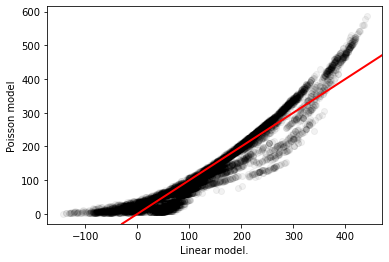

In [255]:
plt.plot(lm2.predict(), pois.predict(), 'ko', alpha=0.05)
plt.axline((0,0), slope=1, color='r', lw=2)
plt.xlabel('Linear model.')
plt.ylabel('Poisson model');

The predictions from the Poisson regression model are correlated with those from the linear model; however, the former are non-negative. As a result the Poisson regression predictions tend to be larger than those from the linear model for either very low or very high levels of ridership.

In this section, we used the `glm()` function with the argument `family = poisson` in order to perform Poisson regression. Other choices for the `family` argument can be used to fit other types of GLMs. For instance, `family = Gamma` fits a gamma regression model.

